# DANA 4830: GROUP PROJECT REPORT (OPTION 1)
Instructor: Monica Nguyen

Group members:
- Huan Le Van
- Andy Nguyen
- Phan Hoang An Nguyen
- Dawn Dang

## Research article

- Paper source: Vogelstein, J. T., Bridgeford, E. W., Tang, M., Zheng, D., Douville, C., Burns, R., & Maggioni, M. (2021). Supervised dimensionality reduction for big data. Nature communications, 12(1), 2872.
- Data source: https://neurodata.io/mri/ (brain image)
- Source code: https://github.com/neurodata/lol


## Introduction

The increasing prevalence of big data across various scientific and industrial domains has necessitated the development of sophisticated methods for data analysis and interpretation. One of the critical challenges in big data analytics is the high-dimensional nature of the data, which can obscure meaningful patterns and relationships. Dimensionality reduction techniques are essential tools that transform high-dimensional data into a lower-dimensional space while preserving its intrinsic structures.

Vogelstein et al. (2021) introduced a novel approach to supervised dimensionality reduction, designed specifically for the challenges posed by big data. Their method, detailed in "Supervised Dimensionality Reduction for Big Data," published in Nature Communications, integrates supervised learning principles with dimensionality reduction techniques to enhance the interpretability and utility of large datasets by Linear Optimal Low-rank projection (LOL)

This report aims to replicate the study conducted by Vogelstein et al. and evaluate the effectiveness of their proposed methodology. By systematically re-implementing the key aspects of their approach, we seek to validate their findings and explore potential improvements or alternative applications. Our investigation is driven by the need to ensure that advanced dimensionality reduction methods can be reliably applied across diverse datasets and yield consistent, actionable insights.

The structure of this report is as follows:
- Section 1 provides a comprehensive dataset tranformation of brain images into numpy array.
- Section 2 combines arrays from different dataset to the max of our laptops' data processing capability
- Section 3 presents the results of our replication efforts, applying 4 different feature reduction techniques mentioned in the paper, accompanied by a discussion of the findings.
- Finally, we offer conclusions by ROC, Cohen's kappa value comparison and suggestions for future research directions.

## Import the library

In [ ]:
!pip install nilearn

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.plotting import plot_anat, plot_epi
from nilearn import image, plotting
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# I. Preparing Data

Data store structure:  
Database --> Patient ID --> Session 1 --> anat_1 --> anat.nii.gz

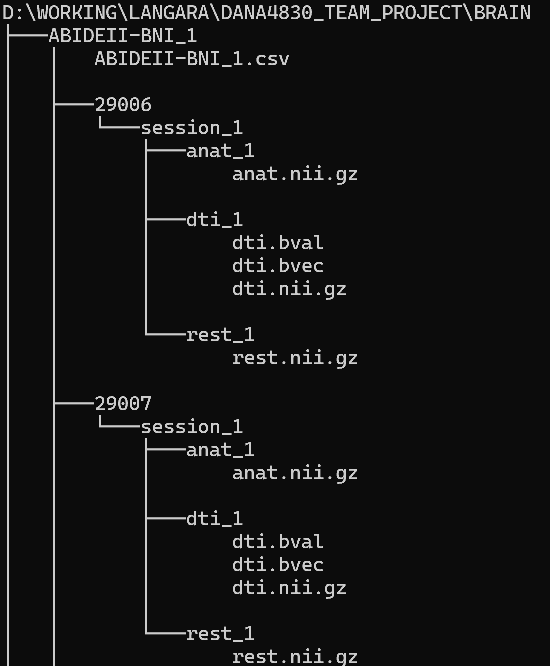

Lets visualize some images to see original data:

In [ ]:
# Load the anatomical image
anat_img = nib.load('./Brain/ABIDEII-BNI_1/29006/session_1/anat_1/anat.nii.gz')
anat_data = anat_img.get_fdata()

# Load the resting-state image
rest_img = nib.load('./Brain/ABIDEII-BNI_1/29006/session_1//rest_1/rest.nii.gz')
rest_data = rest_img.get_fdata()


# Visualize the anatomical image using nilearn
plot_anat(anat_img, title="Anatomical Image (Nilearn)")
plt.show()

# Visualize a specific timepoint of the resting-state image using nilearn
# For example, visualize the first, middle, and last time points
num_timepoints = rest_img.shape[3]
timepoints_to_visualize = [0, num_timepoints // 2, num_timepoints - 1]

for t in timepoints_to_visualize:
    plot_epi(rest_img.slicer[:, :, :, t], title=f"Resting-State Image (Timepoint {t})")
    plt.show()

The MRI data includes 2 types: Anatomical image and Rest state Image (time series data). In the scope of this project, we just deal with anatomical image.

Load data, this part is to run one time only. Aiming to export raw data scan image to numpy array:

In [ ]:
#function to resize image into an unique size:
import os
def resample_image(image, target_shape):
    factors = [float(t) / float(s) for t, s in zip(target_shape, image.shape)]
    return ndimage.zoom(image, factors, order=1)

paths = './Brain'

target_shape = (128, 128, 128)

subfolder_names = [f.name for f in os.scandir(paths) if f.is_dir()]
error_log_path = 'error_log.txt'

with open(error_log_path, 'w') as error_log:
    for folder in subfolder_names:
        try:

            features = []
            labels = []

            patient_data_path = os.path.join(paths, folder, folder + ".csv")
            patient_data = pd.read_csv(patient_data_path, encoding='latin-1')

            patient_ids = patient_data['SUB_ID'].values
            dx_labels = patient_data['DX_GROUP'].values  # Assuming DX_GROUP is the target variable

            print(f'{folder}-file: {patient_data_path}')
            df_customer =  patient_data[['SUB_ID', 'SEX', 'DX_GROUP']]

            for i, patient_id in enumerate(patient_ids):
                try:
                    #get image path:
                    anat_image_path = os.path.join(paths, folder, str(patient_id), 'session_1/anat_1/anat.nii.gz')

                    #read image file:
                    img = nib.load(anat_image_path).get_fdata()

                    #resize image
                    img_resampled = resample_image(img, target_shape)

                    #flatten image:
                    anat_flat = img_resampled.flatten()

                    #convert array to float32
                    anat_flat = anat_flat.astype(np.float32)

                    features.append(anat_flat)
                    labels.append(dx_labels[i])

                    print(f'{folder}-{patient_id}- org size: {img.shape} - resize to : {img_resampled.shape} -- flatten to: {anat_flat.shape}')

                except Exception as e:
                    error_log.write(f"Error processing images for patient {patient_id} in {folder}: {str(e)}\n")

            features = np.array(features)
            labels = np.array(labels)

            # Save features and labels for later use. Create folder Resize_Data at the same location of this notebook
            np.save(f'./Resize_Data/features_{folder}_resized.npy', features)  
            df_customer.to_csv(f'./Resize_Data/patients_{folder}.csv')

        except Exception as e:
            error_log.write(f"Error processing folder {folder}: {str(e)}\n")






**Note: After exporting data, restart notebook to release memory!!!**

# II. Read data

All data after flatterned has been saved in separate file, each file corresponded to one patient. NPY file contains all features information while CSV file has target feature 'DX_GROUP' (binary: 0 = normal, 1 = brain injury)

In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.plotting import plot_anat, plot_epi
from nilearn import image, plotting
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [3]:
import glob

# Define the path to the data folder
data_folder = './Resize_Data/'

# Read and concatenate all CSV files from the data folder
csv_files = [
        'patients_ABIDEII-ETH_1.csv',
        'patients_ABIDEII-GU_1.csv',
        'patients_ABIDEII-IP_1.csv',
        'patients_ABIDEII-IU_1.csv',
        'patients_ABIDEII-KKI_1.csv',
        'patients_ABIDEII-NYU_1.csv',
        'patients_ABIDEII-NYU_2.csv',
        'patients_ABIDEII-BNI_1.csv',
        'patients_ABIDEII-EMC_1.csv'
]

df_list = [pd.read_csv(data_folder + file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)
y = df['DX_GROUP'].map({1:1,2:0})

# Load and concatenate all npy files from the data folder
npy_files = [
    'features_ABIDEII-ETH_1_resized.npy',
    'features_ABIDEII-GU_1_resized.npy',
    'features_ABIDEII-IP_1_resized.npy',
    'features_ABIDEII-IU_1_resized.npy',
    'features_ABIDEII-KKI_1_resized.npy',
    'features_ABIDEII-NYU_1_resized.npy',
    'features_ABIDEII-NYU_2_resized.npy',
    'features_ABIDEII-BNI_1_resized.npy',
    'features_ABIDEII-EMC_1_resized.npy'
]

npy_list = [np.load(data_folder + file) for file in npy_files]
X = np.concatenate(npy_list, axis=0)

# Display the resulting DataFrame and train_img shape
print("Concatenated DataFrame shape:", y.shape)
print("Concatenated train_img shape:", X.shape)

Concatenated DataFrame shape: (667,)
Concatenated train_img shape: (667, 262144)


In [4]:
# Split data to train - test with ratio 70 - 30
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)

# Recheck check the data size
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((466, 262144), (466,), (201, 262144), (201,))

In [5]:
y_train.value_counts(), y_test.value_counts()

(0    263
 1    203
 Name: DX_GROUP, dtype: int64,
 0    111
 1     90
 Name: DX_GROUP, dtype: int64)

In [6]:
# Scale data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# III. Apply dimension reduction methods

## 1. Random Projection (RP)

### 1.1. Feature reduction with Random Projection

To identify the optimal number of components require for Sparse Random Projection, we run through the performance with Logistic Regression at different number of components and compare.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import make_scorer, recall_score



n_components_range = [25, 50, 100, 200, 300]

# Evaluate performance for each number of components
scores = []
for n_components in n_components_range:
    rp = SparseRandomProjection(n_components=n_components, random_state=42)
    train_img_rp = rp.fit_transform(X_train_scaled)

    # Use LDA as a simple classifier
    clf = LDA()
    # scorer = make_scorer(recall_score, average='macro')
    
    cv_scores = cross_val_score(clf, train_img_rp, y_train, cv=3, scoring='accuracy')
    mean_score = np.mean(cv_scores)

    scores.append(mean_score)
    print(f"Components: {n_components}, CV Accuracy: {mean_score:.4f}")

index_max = scores.index(max(scores))
n_components_optimized = n_components_range[index_max]
print(f'Optimized number of components is {n_components_optimized} with accuracy of {scores[index_max]}')

Components: 25, CV Accuracy: 0.5536
Components: 50, CV Accuracy: 0.5708
Components: 100, CV Accuracy: 0.5515
Components: 200, CV Accuracy: 0.5322
Components: 300, CV Accuracy: 0.5086
Optimized number of components is 50 with accuracy of 0.5707885304659498


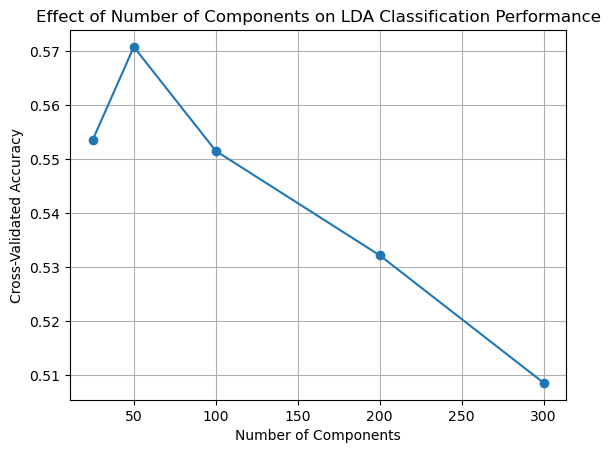

In [8]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(n_components_range, scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of Number of Components on LDA Classification Performance')
plt.grid(True)
plt.show()

In [9]:
# Apply Random Projection

rp = SparseRandomProjection(n_components=n_components_optimized, random_state=42)
train_img_rp = rp.fit_transform(X_train_scaled)
test_img_rp = rp.transform(X_test_scaled)

In [10]:
print(f"Original shape: {X_train.shape}")
print(f"Reduced shape: {train_img_rp.shape}")

Original shape: (466, 262144)
Reduced shape: (466, 50)


### 1.2. LDA Classifier

In [11]:
# Initialize the LDA classifier model
lda = LDA()
# Train the model
lda.fit(train_img_rp, y_train)

# Make predictions
y_pred_rp = lda.predict(test_img_rp)

### 1.3. RandomForest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(train_img_rp, y_train)

# Make predictions on the training set
train_pred_rf_rp= rf.predict(train_img_rp)

# Make predictions on the test set
y_pred_rf_rp = rf.predict(test_img_rp)

In [13]:
# Comparison
report_lda_rp = classification_report(y_test, y_pred_rp, output_dict=True)
report_rf_rp = classification_report(y_test, y_pred_rf_rp, output_dict=True)

# Print detailed classification reports
print('Random Projection feature reduction and LDA model')
print(classification_report(y_test, y_pred_rp))

print('Classification Report for RandomForest:')
print(classification_report(y_test, y_pred_rf_rp))

# Extract relevant metrics
lda_accuracy = report_lda_rp['accuracy']
rf_accuracy = report_rf_rp['accuracy']
lda_precision_class_0 = report_rf_rp['0']['precision']
lda_recall_class_1 = report_rf_rp['1']['recall']

# Create summary with inserted numbers
summary = f"""
**- Summary:**
  - LDA Classifier provides lower accuracy ({lda_accuracy:.2f}) when compared to RandomForest Classifier ({rf_accuracy:.2f}).
  - Random Projection on RandomForest classifier has Recall {lda_recall_class_1 * 100:.0f}% for class 1 (Brain injury), meaning it correctly identifies {lda_recall_class_1 * 100:.0f}% of the actual cases with brain injury.
  - Precision of class 0 (normal case) is {lda_precision_class_0 * 100:.0f}%, meaning that {lda_precision_class_0 * 100:.0f}% of the instances predicted as class 0 were actually class 0.
  - The overall accuracy of the RandomForest model is {rf_accuracy * 100:.0f}%, meaning that {rf_accuracy * 100:.0f}% of the total predictions made by the model were correct.
"""

print(summary)

Random Projection feature reduction and LDA model
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       111
           1       0.54      0.39      0.45        90

    accuracy                           0.58       201
   macro avg       0.57      0.56      0.55       201
weighted avg       0.57      0.58      0.56       201

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.60      0.77      0.68       111
           1       0.57      0.37      0.45        90

    accuracy                           0.59       201
   macro avg       0.59      0.57      0.56       201
weighted avg       0.59      0.59      0.57       201


**- Summary:**
  - LDA Classifier provides lower accuracy (0.58) when compared to RandomForest Classifier (0.59).
  - Random Projection on RandomForest classifier has Recall 37% for class 1 (Brain injury), meaning it correctly identifies 37% of the actual

## 2. Linear Discriminant Analysis (LDA)

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### 2.1 LDA Classifier

In [15]:
# Reduce feature with LDA and apply it for classifier model
lda_classifier = LDA()
lda_classifier.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_lda = lda_classifier.predict(X_test_scaled)

### 2.1 RandomForest Classifier

In [16]:
# Apply LDA for feature reduction with 1 components (number of class - 1)
lda = LDA(n_components=1)
train_img_lda = lda.fit_transform(X_train_scaled, y_train)
test_img_lda = lda.transform(X_test_scaled)

Re-run with Random Forest classifier on the data reduced by LDA

In [17]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(train_img_lda, y_train)

# Make predictions on the test set
y_pred_rf_lda = rf.predict(test_img_lda)

In [18]:
from sklearn.metrics import classification_report

# Get classification reports as dictionaries
report_lda = classification_report(y_test, y_pred_lda, output_dict=True)
report_rf_lda = classification_report(y_test, y_pred_rf_lda, output_dict=True)

# Print detailed classification reports
print('LDA Classifier with LDA features')
print(classification_report(y_test, y_pred_lda))

print('RandomForest Classifier with LDA features')
print(classification_report(y_test, y_pred_rf_lda))

# Extract relevant metrics
lda_accuracy = report_lda['accuracy']
rf_accuracy = report_rf_lda['accuracy']
rf_precision_class_0 = report_rf_lda['0']['precision']
rf_recall_class_1 = report_rf_lda['1']['recall']

# Create summary with inserted numbers
summary = f"""
**- Summary:**
  - LDA Classifier provides lower accuracy ({lda_accuracy:.2f}) when compared to RandomForest Classifier ({rf_accuracy:.2f}).
  - Random Projection on RandomForest classifier has Recall {rf_recall_class_1 * 100:.0f}% for class 1 (Brain injury), meaning it correctly identifies {rf_recall_class_1 * 100:.0f}% of the actual cases with brain injury.
  - Precision of class 0 (normal case) is {rf_precision_class_0 * 100:.0f}%, meaning that {rf_precision_class_0 * 100:.0f}% of the instances predicted as class 0 were actually class 0.
  - The overall accuracy of the RandomForest model is {rf_accuracy * 100:.0f}%, meaning that {rf_accuracy * 100:.0f}% of the total predictions made by the model were correct.
"""

print(summary)

LDA Classifier with LDA features
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       111
           1       0.53      0.57      0.55        90

    accuracy                           0.58       201
   macro avg       0.58      0.58      0.58       201
weighted avg       0.58      0.58      0.58       201

RandomForest Classifier with LDA features
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       111
           1       0.51      0.60      0.55        90

    accuracy                           0.56       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.57      0.56      0.56       201


**- Summary:**
  - LDA Classifier provides lower accuracy (0.58) when compared to RandomForest Classifier (0.56).
  - Random Projection on RandomForest classifier has Recall 60% for class 1 (Brain injury), meaning it correctly identifies 60% of the actual cases with bra

## 3. Linear Optimal Low-Rank Projection (LOL)

### 3.1. Feature reduction with LOL

Find optimal components for LOL

In [19]:
!pip install lolP

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from lol import LOL
import time
#find optimal
# List to store results
results = []
n_components_range = range(10, 201, 30)
# Loop over different values of n_components
for n_components in n_components_range:
    start = time.time()
    # Initialize LOL with desired number of components
    lol = LOL(n_components=n_components, svd_solver='full')

    # Fit LOL on the standardized data and transform it
    X_train_lol = lol.fit_transform(X_train_scaled, y_train)
    X_test_lol = lol.transform(X_test)

    # Train and evaluate LDA Model
    lda = LDA()

    cv_scores = cross_val_score(lda, X_train_lol, y_train, cv=3, scoring='accuracy')
    mean_score = np.mean(cv_scores)
    durration = time.time() - start

    # Store results
    results.append(mean_score)

    print(f'Processed n_components:{n_components} in {durration}(s) with accuracy of {mean_score}')

index_max = results.index(max(results))
n_components_optimized = n_components_range[index_max]
print(f'Optimized number of components is {n_components_optimized} with accuracy of {results[index_max]}')



Processed n_components:10 in 43.58442044258118(s) with accuracy of 0.7359663633857183
Processed n_components:40 in 43.22716784477234(s) with accuracy of 0.7553625585883651
Processed n_components:70 in 43.873130083084106(s) with accuracy of 0.7617452440033086
Processed n_components:100 in 43.1424446105957(s) with accuracy of 0.7532533774469258
Processed n_components:130 in 43.40094590187073(s) with accuracy of 0.7488833746898264
Processed n_components:160 in 43.39975357055664(s) with accuracy of 0.7404052936311002
Processed n_components:190 in 43.67098641395569(s) with accuracy of 0.6867659222497933
Optimized number of components is 70 with accuracy of 0.7617452440033086


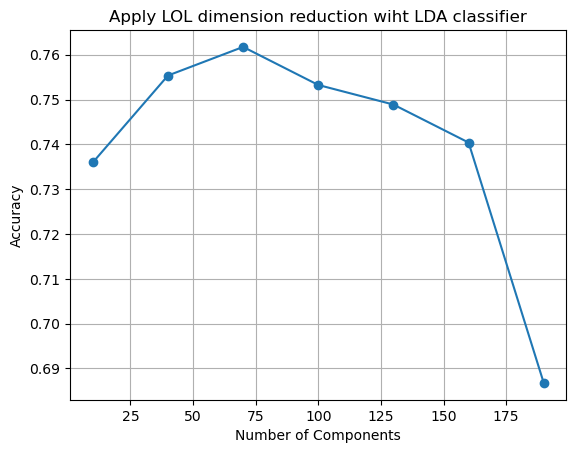

In [21]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(n_components_range, results, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Apply LOL dimension reduction wiht LDA classifier')
plt.grid(True)
plt.show()

Based on the result the optimal number for components will be 60

### 3.2. LDA Classifier

In [22]:
# Initialize LOL with the optimal number of components
lol = LOL(n_components=n_components_optimized, svd_solver='full')

# Fit LOL on the scaled training data and transform both training and test data
X_train_lol = lol.fit_transform(X_train_scaled, y_train)
X_test_lol = lol.transform(X_test_scaled)

# Train and evaluate LDA Model on LOL-transformed data
lda = LDA()
lda.fit(X_train_lol, y_train)
y_pred_lol = lda.predict(X_test_lol)



### 3.3 RandomForest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_lol, y_train)

# Make predictions on the test set
y_pred_rf_lol = rf.predict(X_test_lol)

In [24]:
# Get classification reports as dictionaries
report_lol_lda = classification_report(y_test, y_pred_lol, output_dict=True)
report_rf_lol = classification_report(y_test, y_pred_rf_lol, output_dict=True)

# Print detailed classification reports
print('LDA Classifier with with LOL features')
print(classification_report(y_test, y_pred_lol))

print('RandomForest Classifier with LOL features')
print(classification_report(y_test, y_pred_rf_lol))

# Extract relevant metrics
lol_lda_accuracy = report_lol_lda['accuracy']
rf_lol_accuracy = report_rf_lol['accuracy']
lol_lda_precision_class_0 = report_lol_lda['0']['precision']
lol_lda_recall_class_1 = report_lol_lda['1']['recall']

# Create summary with inserted numbers
summary = f"""
**- Summary:**
  - LDA Classifier provides better accuracy ({lol_lda_accuracy:.2f}) when compared to RandomForest Classifier ({rf_lol_accuracy:.2f}).
  - Linear Optimal Low-Rank Projection (LOL) on LDA classifier has Recall {lol_lda_recall_class_1 * 100:.0f}% for class 1 (Brain injury), meaning it correctly identifies {lol_lda_recall_class_1 * 100:.0f}% of the actual cases with brain injury.
  - Precision of class 0 (normal case) is {lol_lda_precision_class_0 * 100:.0f}%, meaning that {lol_lda_precision_class_0 * 100:.0f}% of the instances predicted as class 0 were actually class 0.
  - The overall accuracy of the model is {lol_lda_accuracy * 100:.0f}%, meaning that {lol_lda_accuracy * 100:.0f}% of the total predictions made by the model were correct.
"""

print(summary)

LDA Classifier with with LOL features
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       111
           1       0.59      0.44      0.51        90

    accuracy                           0.61       201
   macro avg       0.61      0.60      0.59       201
weighted avg       0.61      0.61      0.60       201

RandomForest Classifier with LOL features
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       111
           1       0.51      0.48      0.49        90

    accuracy                           0.56       201
   macro avg       0.56      0.55      0.55       201
weighted avg       0.56      0.56      0.56       201


**- Summary:**
  - LDA Classifier provides better accuracy (0.61) when compared to RandomForest Classifier (0.56).
  - Linear Optimal Low-Rank Projection (LOL) on LDA classifier has Recall 44% for class 1 (Brain injury), meaning it correctly identifies 44% of the a

## 4. Principal Components Analysis (PCA)

### 4.1. Feature Reduction with PCA

In [25]:
pca = PCA()

# Fit on training set only.
pca.fit(X_train_scaled)
# Apply transform to both the training set and the test set.
train_img_pca = pca.transform(X_train_scaled)


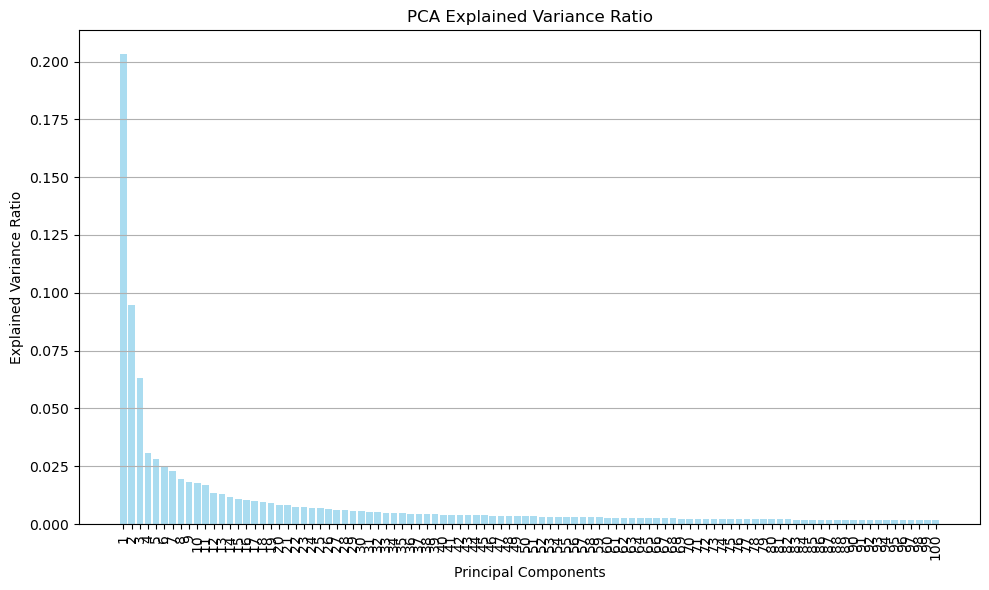

In [26]:
explained_variance_ratio = pca.explained_variance_ratio_[:100]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1), rotation=90)  # Rotate x-axis labels by 90 degrees
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [27]:
pca.explained_variance_ratio_.cumsum()

array([0.20332667, 0.29802448, 0.36105132, 0.3918036 , 0.42012638,
       0.44509912, 0.46821132, 0.48767436, 0.505788  , 0.52336836,
       0.54045093, 0.5538947 , 0.56711334, 0.5789394 , 0.5895764 ,
       0.59995073, 0.610032  , 0.6195666 , 0.62876827, 0.63723284,
       0.6454452 , 0.6530168 , 0.6602943 , 0.66711175, 0.673902  ,
       0.68021923, 0.68640506, 0.6922858 , 0.69795823, 0.70351505,
       0.70870805, 0.7137838 , 0.71875244, 0.7236707 , 0.7283361 ,
       0.7328976 , 0.7373215 , 0.7415261 , 0.7456919 , 0.7498257 ,
       0.75395626, 0.7580159 , 0.7619075 , 0.76575273, 0.7695438 ,
       0.7731138 , 0.77662534, 0.78011405, 0.7834942 , 0.78681076,
       0.7901121 , 0.7933291 , 0.79650384, 0.7996309 , 0.8027223 ,
       0.80577624, 0.8087714 , 0.811732  , 0.81465554, 0.81747925,
       0.82022035, 0.8229126 , 0.82557577, 0.8282193 , 0.83086056,
       0.8334719 , 0.8360087 , 0.8384628 , 0.84087825, 0.84329283,
       0.84565276, 0.84795403, 0.85023385, 0.8524768 , 0.85470

Apply Kaiser's criterion to choose n_components_optimized:

In [28]:
explained_variance = pca.explained_variance_ratio_
average_explained_variance = np.mean(explained_variance)
n_components_optimized = explained_variance[explained_variance > average_explained_variance].shape[0]
n_components_optimized

77

In [29]:
captured_variance = pca.explained_variance_ratio_.cumsum()[n_components_optimized]
print(f'With {n_components_optimized} PCs, {round(captured_variance*100,2)}% of variance is captured')

With 77 PCs, 86.12% of variance is captured


In [30]:
# Apply PCA

pca = PCA(n_components=n_components_optimized)
pca.fit(X_train_scaled)

train_img_pca = pca.transform(X_train_scaled)
test_img_pca = pca.transform(X_test_scaled)


### 4.2. LDA Classifier

In [31]:
lda = LDA()

# Train the model
lda.fit(train_img_pca, y_train)
# evaluate model
y_pred_pca = lda.predict(test_img_pca)

### 4.3 RandomForest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(train_img_pca, y_train)

# Make predictions on the training set
train_pred_rf_pca= rf.predict(train_img_pca)

# Make predictions on the test set
y_pred_rf_pca = rf.predict(test_img_pca)

In [33]:
# Get classification reports as dictionaries
report_pca_lda = classification_report(y_test, y_pred_pca, output_dict=True)
report_rf_pca = classification_report(y_test, y_pred_rf_pca, output_dict=True)

# Print detailed classification reports
print('LDA Classifier with PCA features')
print(classification_report(y_test, y_pred_pca))

print('RandomForest Classifier with PCA features')
print(classification_report(y_test, y_pred_rf_pca))

# Extract relevant metrics
pca_lda_accuracy = report_pca_lda['accuracy']
rf_pca_accuracy = report_rf_pca['accuracy']
pca_lda_precision_class_0 = report_pca_lda['0']['precision']
pca_lda_recall_class_1 = report_pca_lda['1']['recall']

# Create summary with inserted numbers
summary = f"""
**- Summary:**
  - LDA Classifier provides better accuracy ({pca_lda_accuracy:.2f}) when compared to RandomForest Classifier ({rf_pca_accuracy:.2f}).
  - Principal Component Analysis (PCA) on LDA classifier has Recall {pca_lda_recall_class_1 * 100:.0f}% for class 1 (Brain injury), meaning it correctly identifies {pca_lda_recall_class_1 * 100:.0f}% of the actual cases with brain injury.
  - Precision of class 0 (normal case) is {pca_lda_precision_class_0 * 100:.0f}%, meaning that {pca_lda_precision_class_0 * 100:.0f}% of the instances predicted as class 0 were actually class 0.
  - The overall accuracy of the model is {pca_lda_accuracy * 100:.0f}%, meaning that {pca_lda_accuracy * 100:.0f}% of the total predictions made by the model were correct.
"""

print(summary)

LDA Classifier with PCA features
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       111
           1       0.64      0.43      0.52        90

    accuracy                           0.64       201
   macro avg       0.64      0.62      0.61       201
weighted avg       0.64      0.64      0.62       201

RandomForest Classifier with PCA features
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       111
           1       0.57      0.49      0.53        90

    accuracy                           0.61       201
   macro avg       0.60      0.60      0.60       201
weighted avg       0.60      0.61      0.60       201


**- Summary:**
  - LDA Classifier provides better accuracy (0.64) when compared to RandomForest Classifier (0.61).
  - Principal Component Analysis (PCA) on LDA classifier has Recall 43% for class 1 (Brain injury), meaning it correctly identifies 43% of the actual cases

# ROC

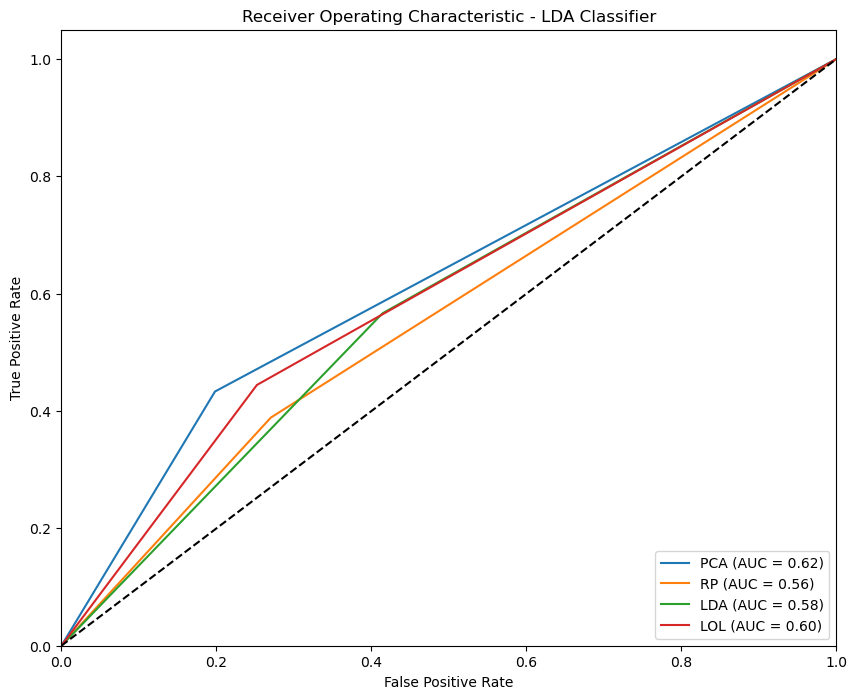

In [34]:
from sklearn.metrics import roc_curve, auc

y_scores = {
    'PCA': y_pred_pca,
    'RP': y_pred_rp,
    'LDA': y_pred_lda,
    'LOL': y_pred_lol
}

plt.figure(figsize=(10, 8))

for method, y_score in y_scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LDA Classifier')
plt.legend(loc='lower right')
plt.show()

- Interpret: AUC are similar across PCA and LOL. LDA gave the lowest AUC.

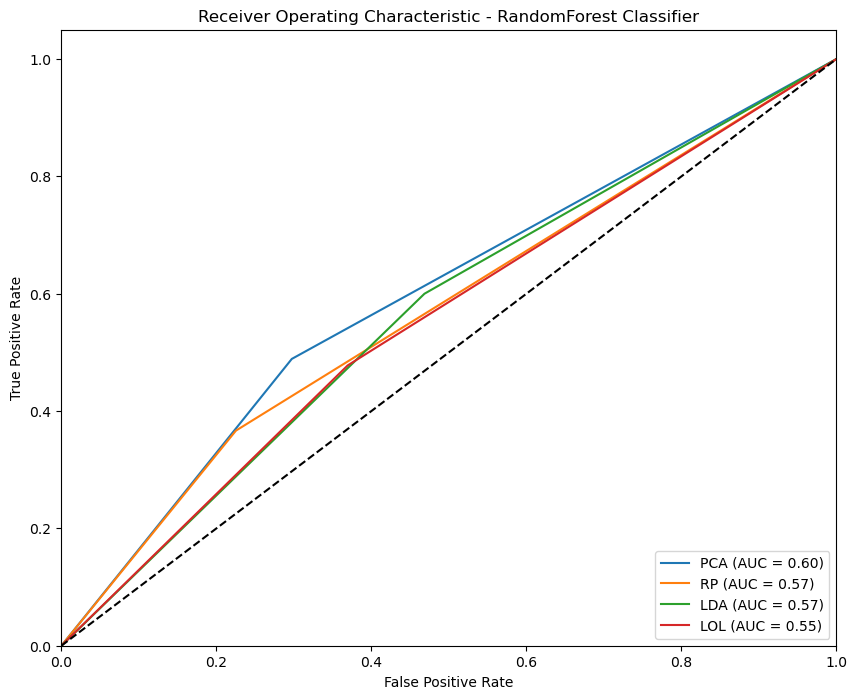

In [35]:
from sklearn.metrics import roc_curve, auc

y_scores = {
    'PCA': y_pred_rf_pca,
    'RP': y_pred_rf_rp,
    'LDA': y_pred_rf_lda,
    'LOL': y_pred_rf_lol
}

plt.figure(figsize=(10, 8))

for method, y_score in y_scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - RandomForest Classifier')
plt.legend(loc='lower right')
plt.show()

- Interpret: 
    - When change to RandomForest Classifier AUC are similar across all type. 
    - LDA still the lowest but that incrase from 0.50 to 0.52, while other methods reduced slightly compared to LDA Classifier

# Cohen's Kappa

Results Table:
  Model  Cohen's Kappa
0   PCA       0.242527
1    RP       0.121820
2   LDA       0.151140
3   LOL       0.196741


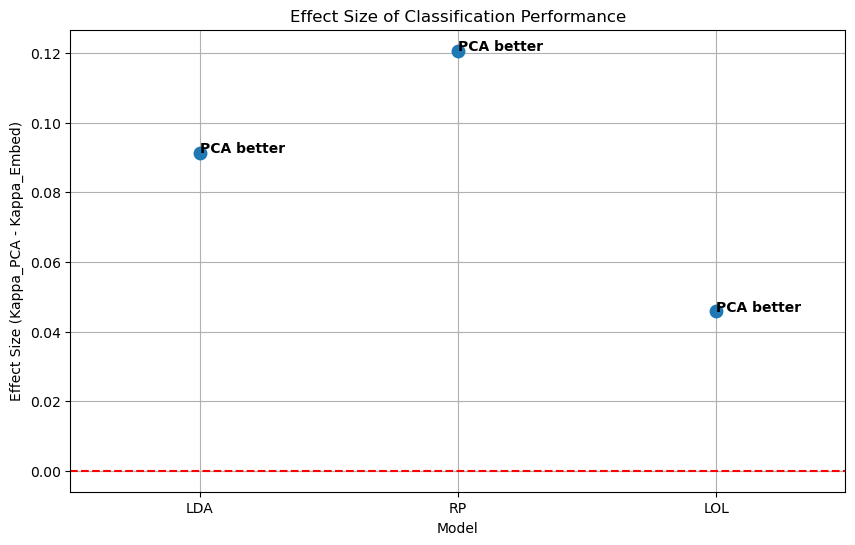

In [36]:
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

#Calculate Cohen's Kappa
kappa_pca = cohen_kappa_score(y_test, y_pred_pca)
kappa_rp = cohen_kappa_score(y_test,y_pred_rp)
kappa_lda = cohen_kappa_score(y_test,y_pred_lda)
kappa_lol = cohen_kappa_score(y_test,y_pred_lol)


# Calculate effect sizes
effect_sizes = {
    'LDA': kappa_pca - kappa_lda,
    'RP': kappa_pca - kappa_rp,
    'LOL': kappa_pca - kappa_lol
}

# Prepare data for beeswarm plot
effect_size_data = pd.DataFrame({
    'Model': list(effect_sizes.keys()),
    'Effect Size': list(effect_sizes.values())
})

# Display the table
results_table = pd.DataFrame({
    'Model': ['PCA', 'RP', 'LDA', 'LOL'],
    'Cohen\'s Kappa': [kappa_pca, kappa_rp, kappa_lda, kappa_lol]
})

print("Results Table:")
print(results_table)

# Create beeswarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Model', y='Effect Size', data=effect_size_data, size=10)
plt.axhline(0, color='red', linestyle='--')  # Add dotted line at y=0
# Annotate points with text
for i in range(len(effect_size_data)):
    row = effect_size_data.iloc[i]
    if row['Effect Size'] > 0:
        plt.text(i, row['Effect Size'], 'PCA better', horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        plt.text(i, row['Effect Size'], 'PCA worse', horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.xlabel('Model')
plt.ylabel('Effect Size (Kappa_PCA - Kappa_Embed)')
plt.title('Effect Size of Classification Performance')
plt.grid(True)
plt.show()

Cohen's Kappa (𝜅) is a statistical measure used to evaluate the level of agreement between two raters or observers for categorical items. It accounts for the possibility of the agreement occurring by chance. The value of Cohen's Kappa ranges from -1 to 1, where:

1 indicates perfect agreement,

0 indicates no agreement beyond what is expected by chance,

Negative values indicate less than chance agreement.

# Classification table

  Model  Accuracy  Precision    Recall  F1 Score       AUC
0    RP  0.577114   0.567025  0.559309  0.553742  0.559309
1   LDA  0.577114   0.575387  0.576126  0.575053  0.576126
2   LOL  0.611940   0.606148  0.596096  0.593328  0.596096
3   PCA  0.636816   0.637529  0.617568  0.612860  0.617568


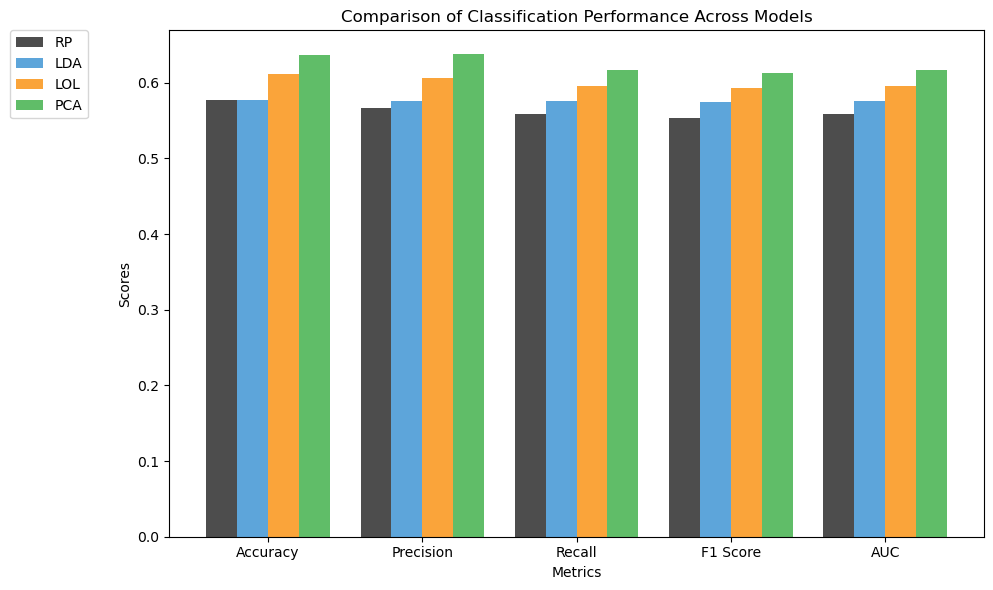

In [37]:
from sklearn.metrics import classification_report, roc_auc_score
# Calculate metrics using classification_report and roc_auc_score
report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
report_rp = classification_report(y_test, y_pred_rp, output_dict=True)
report_lda = classification_report(y_test, y_pred_lda, output_dict=True)
report_lol = classification_report(y_test, y_pred_lol, output_dict=True)

metrics_pca = {
    'accuracy': report_pca['accuracy'],
    'precision': report_pca['macro avg']['precision'],
    'recall': report_pca['macro avg']['recall'],
    'f1': report_pca['macro avg']['f1-score'],
    'auc': roc_auc_score(y_test, y_pred_pca)
}

metrics_rp = {
    'accuracy': report_rp['accuracy'],
    'precision': report_rp['macro avg']['precision'],
    'recall': report_rp['macro avg']['recall'],
    'f1': report_rp['macro avg']['f1-score'],
    'auc': roc_auc_score(y_test, y_pred_rp)
}

metrics_lda = {
    'accuracy': report_lda['accuracy'],
    'precision': report_lda['macro avg']['precision'],
    'recall': report_lda['macro avg']['recall'],
    'f1': report_lda['macro avg']['f1-score'],
    'auc': roc_auc_score(y_test, y_pred_lda)
}

metrics_lol = {
    'accuracy': report_lol['accuracy'],
    'precision': report_lol['macro avg']['precision'],
    'recall': report_lol['macro avg']['recall'],
    'f1': report_lol['macro avg']['f1-score'],
    'auc': roc_auc_score(y_test, y_pred_lol)
}

# Create a DataFrame to display the results
results = pd.DataFrame({
    'Model': [ 'RP', 'LDA', 'LOL','PCA'],
    'Accuracy': [metrics_rp['accuracy'], metrics_lda['accuracy'], metrics_lol['accuracy'],  metrics_pca['accuracy']],
    'Precision': [metrics_rp['precision'], metrics_lda['precision'], metrics_lol['precision'], metrics_pca['precision']],
    'Recall':  [metrics_rp['recall'], metrics_lda['recall'], metrics_lol['recall'], metrics_pca['recall']],
    'F1 Score': [metrics_rp['f1'], metrics_lda['f1'], metrics_lol['f1'], metrics_pca['f1']],
    'AUC': [metrics_rp['auc'], metrics_lda['auc'], metrics_lol['auc'], metrics_pca['auc']]
})

# Display the results
print(results)

# Plotting the bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

# Use a more neutral color palette
colors = ['#4D4D4D', '#5DA5DA', '#FAA43A', '#60BD68']

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - 1.5*width, results.loc[0, metrics], width, label='RP', color=colors[0])
rects2 = ax.bar(x - 0.5*width, results.loc[1, metrics], width, label='LDA', color=colors[1])
rects3 = ax.bar(x + 0.5*width, results.loc[2, metrics], width, label='LOL', color=colors[2])
rects4 = ax.bar(x + 1.5*width, results.loc[3, metrics], width, label='PCA', color=colors[3])

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classification Performance Across Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(bbox_to_anchor=(-0.1, 1), loc='upper right', borderaxespad=0.)

fig.tight_layout()

plt.show()

- Based on the the graph above, the performance of classification by LOL are comparable with PCA and RP
- This might be due to the loss of information since we had flattened the original images from millions features.
- The limit of our work is none other than not having enough computing resources (CPU, especially RAM) to handle such big data
- Recommendations from one of the authors, Dr. Eric Bridgeford, was that using Docker environment with flashLOL. More research must be conducted for this route.

# 3D CNN Deep learning with original data

In [ ]:
import nibabel as nib
from scipy import ndimage
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
def load_mri_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def resample_image(image, target_shape):
    factors = [float(t) / float(s) for t, s in zip(target_shape, image.shape)]
    return ndimage.zoom(image, factors, order=1)

In [ ]:
paths = './Brain'
subfolder_names = [f.name for f in os.scandir(paths) if f.is_dir()]
error_log_path = 'error_log.txt'
mri_images = []
target_shape = (128, 128, 128)


df_customer = pd.DataFrame(columns=['SUB_ID', 'SEX', 'DX_GROUP'])


with open(error_log_path, 'w') as error_log:
    for folder in subfolder_names:
        try:


            patient_data_path = os.path.join(paths, folder, folder + ".csv")
            patient_data = pd.read_csv(patient_data_path, encoding='latin-1')

            patient_ids = patient_data['SUB_ID'].values
            dx_labels = patient_data['DX_GROUP'].values  # Assuming DX_GROUP is the target variable

            print(f'{folder}-file: {patient_data_path}')

            df_customer = pd.concat([df_customer, patient_data[['SUB_ID', 'SEX', 'DX_GROUP']]], axis=0)

            for i, patient_id in enumerate(patient_ids):
                try:
                    anat_image_path = os.path.join(paths, folder, str(patient_id), 'session_1/anat_1/anat.nii.gz')
                    img_data = load_mri_image(anat_image_path)
                    image_data_resized = resample_image(img_data,target_shape)

                    mri_images.append(image_data_resized)

                    print(f'{folder}-{patient_id}- org size: {img_data.shape} - resize to : {image_data_resized.shape}')
                except Exception as e:
                    error_log.write(f"Error processing images for patient {patient_id} in {folder}: {str(e)}\n")

            # features = np.array(features)
            # labels = np.array(labels)
            # Save features and labels for later use
            #np.save(f'./features_{folder}_resized.npy', features)
            # np.save(f'./labels_sex_{folder}.npy', labels)
            #df_customer.to_csv(f'./patients_{folder}.csv')
        except Exception as e:
            error_log.write(f"Error processing folder {folder}: {str(e)}\n")


ABIDEII-BNI_1-file: ./Brain\ABIDEII-BNI_1\ABIDEII-BNI_1.csv
ABIDEII-BNI_1-29006- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29007- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29008- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29009- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29010- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29012- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29013- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29015- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29017- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29025- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29026- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29027- org size: (193, 256, 256) - resize to : (128, 128, 128)
ABIDEII-BNI_1-29

In [ ]:
len(mri_images)

112

- It has proven to be challenging to run the original image so we decided to resize the image from (193,256,256) to (128,128,128) to compensate for the lack of computing resources. Furthermore, a balance dataset with around 112 patients was selected for this pilot run

In [ ]:
mri_images = np.array(mri_images)
mri_images = mri_images / np.max(mri_images)
print(f"Shape of MRI images: {mri_images.shape}")


Shape of MRI images: (112, 128, 128, 128)


In [ ]:
labels = df_customer['DX_GROUP'].map({1:1,2:0})
print(f"Shape of label images: {labels.shape}")

Shape of label images: (112,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(mri_images, labels, test_size=0.3, random_state=42)

In [ ]:
y_val.value_counts()

DX_GROUP
1    19
0    15
Name: count, dtype: int64

In [ ]:
# Expand dimension for 3D array for 3D CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
X_train.shape

(78, 128, 128, 128, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the 3D CNN model
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(128, 128, 128, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

d:\Program Files\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 126, 126, 126,  │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 63, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 63, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 61, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 30, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 30, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 14,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 14,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 351232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   179,831,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,110,273 (687.07 MB)

 Trainable params: 180,109,825 (687.06 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 139s 49s/step - accuracy: 0.4108 - loss: 21.6151 - val_accuracy: 0.6176 - val_loss: 0.7170
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 125s 38s/step - accuracy: 0.5516 - loss: 10.7422 - val_accuracy: 0.4412 - val_loss: 0.7315
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 124s 40s/step - accuracy: 0.6757 - loss: 5.4900 - val_accuracy: 0.4412 - val_loss: 0.7567
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 25s/step - accuracy: 0.5722 - loss: 6.2629 - val_accuracy: 0.4412 - val_loss: 0.7154
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 107s 34s/step - accuracy: 0.5853 - loss: 8.0299 - val_accuracy: 0.4118 - val_loss: 0.6953
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 119s 40s/step - accuracy: 0.6579 - loss: 6.4935 - val_accuracy: 0.4412 - val_loss: 0.7031
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 139s 42s/step - accuracy: 0.6475 - loss: 4.9050 - val_accuracy: 0.5588 - val_loss: 0.9233
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 33s/step - accuracy: 0.7443 - loss: 2.9353 - val_accuracy: 0.5588 - val_loss

- In conclusion, the accuracy of CNN was shown to be poorer than conventional classification techniques above. This might be due to the lack of training data (only 58 images). Further data exploration with different computer configuration systems might be needed to expand the scope of this study